<h1>Speech Emotion Recognition-Final Year Project</h1>

<h3>Dataset Path</h3>

In [179]:
data_directory = "Desktop/speech-emotion-recognition-ravdess-data"

<h3>Import Libraries</h3>

In [180]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics

<h3>Functions</h3>

In [181]:
# Emotions in the RAVDESS dataset, different numbers represent different emotion
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

<h5>Extract features from audio files into numpy array</h5>

In [182]:
def extract_feature(data, sr, mfcc, chroma, mel):
    
    """
    extract features from audio files into numpy array
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency
    
    """
    
    if chroma:                          
        stft = np.abs(librosa.stft(data))  
    result = np.array([])
    if mfcc:                          
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:                          
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:                             
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, mel))
        
    return result 

<h3>Data Augmentation Techniques</h3>
    <p>There are two types of data augmentation for audio that we will be using:</p>
    <ul>
        <li><strong>Noise addition:</strong> Add random white noises to the audio.</li>
        <li><strong>Shifting:</strong> Shift the spectrogram in a direction.</li>
    </ul>
    <h5>Add white noise to the audio dataset.</h5>

In [183]:
def noise(data, noise_factor):
    
    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added 

    """
    noise = np.random.randn(len(data)) 
    augmented_data = data + noise_factor * noise
    
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

<h5>Shift the spectogram in a direction</h5>

In [184]:
def shift(data, sampling_rate, shift_max, shift_direction):
    
    """
    shift the spectogram in a direction
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both
    
    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
        
    return augmented_data

<h3>Loading Dataset</h3>

In [185]:
def load_data(save=False):
    
    """
    loading dataset

    Parameters
    ----------
    save : boolean, save the data to disk as .npy

    """
    x, y = [], []
    for file in glob.glob(data_directory + "/Actor_*/*.wav"):
        # load an audio file as a floating point time series.    
        data, sr = librosa.load(file)
        
        # extract features from audio files into numpy array
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)
        
        # get emotion label from the file name
        emotion = emotions[file_name.split("-")[2]]  
        y.append(emotion)

        # add noise to the data
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # shift the data
        s_data = shift(data,sr,0.25,'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)
    
    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)
        
    return np.array(x), y

<h3>Data processing</h3>

<h5>Read in, extract features, and label data</h5>

In [186]:
X, y = load_data(save=True)

#X = np.load("X.npy")
#y = np.load("y.npy")

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

<h5>Encode the data labels</h5>

In [187]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [188]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


<h1>CNN Model Training</h1>
<h4>Define the model and optimizer</h4>

In [129]:
model = Sequential()
model.add(Conv1D(256, 5, padding='same', input_shape=(180, 1)))  # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))  # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))  # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))  # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))  # 7th layer
model.add(Activation('softmax'))
opt = Adam(decay=1e-6)

In [130]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

<h5>Start training the model</h5>

In [131]:
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.1825 - loss: 3.0001 - val_accuracy: 0.3028 - val_loss: 1.9796
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.2840 - loss: 1.9894 - val_accuracy: 0.3463 - val_loss: 1.8780
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3594 - loss: 1.8650 - val_accuracy: 0.4065 - val_loss: 1.7641
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3896 - loss: 1.7925 - val_accuracy: 0.4324 - val_loss: 1.6735
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.4174 - loss: 1.7092 - val_accuracy: 0.4509 - val_loss: 1.6084
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.4471 - loss: 1.6461 - val_accuracy: 0.4824 - val_loss: 1.5542
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4630 - loss: 1.5837 - val_accuracy: 0.4898 - val_loss: 1.4718
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4976 - loss: 1.5162 - val_accuracy: 0.

In [224]:
# After training your model
print("Training Accuracy:", history.history['accuracy'][-1])  # Final training accuracy
print("Validation Accuracy:", history.history['val_accuracy'][-1])  # Final validation accuracy


Training Accuracy: 0.9907407164573669
Validation Accuracy: 0.8916666507720947


<h1>Model evaluation</h1>
<ol>
  <li>Plot learning curve</li>
  <li>Calculate F1 score</li>
</ol>

<h4>Plot the learning curve of the model with its accuracy</h4>

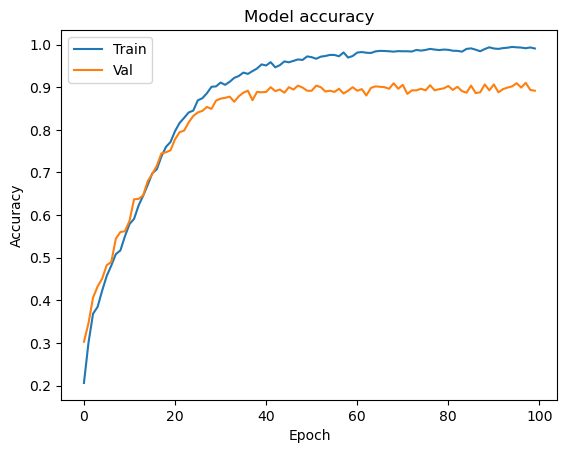

In [132]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

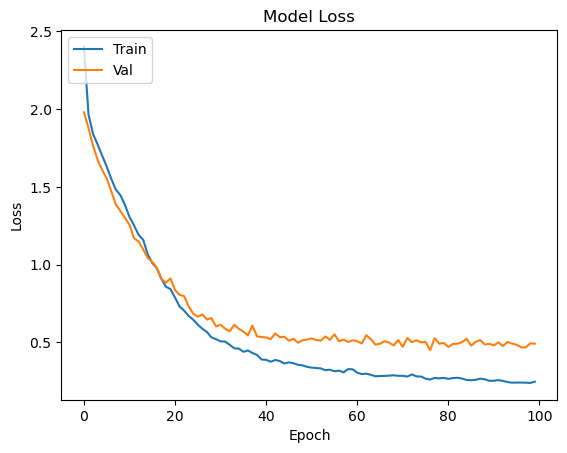

In [133]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

<h5><b>Use the test data to do prediction<b></h5>

In [138]:
y_pred = model.predict(XTestProcessed)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


array([[1.07733875e-04, 9.98165488e-01, 1.20928540e-04, ...,
        1.69078135e-06, 1.45241487e-04, 2.52988189e-04],
       [1.01752556e-03, 2.32261125e-04, 1.23646576e-03, ...,
        2.28212986e-04, 9.86927211e-01, 1.77907292e-04],
       [1.11926794e-02, 8.75086337e-03, 3.06477945e-04, ...,
        2.80771971e-01, 1.72085315e-02, 3.96531224e-02],
       ...,
       [6.88671833e-04, 1.17600874e-04, 3.34106298e-04, ...,
        1.77427381e-03, 2.20425747e-04, 1.72826415e-03],
       [9.99919832e-01, 1.41871590e-06, 6.10091888e-07, ...,
        1.03826815e-05, 2.18560058e-06, 6.13067677e-05],
       [4.06275431e-05, 4.79120536e-05, 1.51544828e-05, ...,
        1.02673992e-04, 2.30345715e-04, 1.14546083e-05]], dtype=float32)

<h5><b>Calculate the F1 score of the model<b></h5>
<h6>F1 score is a measure of a test's accuracy. F1 score combines precision and recall relative to a specific positive class - The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0</h6>

<h3>Model Summary</h3>

In [140]:
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_84 (Conv1D)              │ (None, 180, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_105 (Activation)     │ (None, 180, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_85 (Conv1D)              │ (None, 180, 128)       │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_106 (Activation)     │ (None, 180, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 180, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_86 (Conv1D)              │ (None, 22, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_107 (Activation)     │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_87 (Conv1D)              │ (None, 22, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_108 (Activation)     │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │        22,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_109 (Activation)     │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,056,410 (4.03 MB)

 Trainable params: 352,136 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 704,274 (2.69 MB)

In [157]:
f1_score(y_test,np.argmax(y_pred,axis=-1),average='weighted')

0.8909191272676648

<h3>Save and load the trained model.</h3>

In [199]:
# Save the trained model to disk
if not os.path.exists('models'): 
    os.makedirs('models')

model.save("models/cnn.h5")

In [200]:
# Load the model from disk
loaded_model = keras.models.load_model("models/cnn.h5")

<h3>Playground</h3>

In [191]:
# Load the data and extract features for each sound file
def load_single_data(file):
    x, y = [], []
    file_name = os.path.basename(file)
    emotion = emotions[file_name.split("-")[2]]
    data, sr = librosa.load(file)
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    x.append(feature)
    y.append(emotion)
    return np.array(x), y

In [192]:
XX, yy = load_single_data("Desktop/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-01-01.wav")

In [202]:
yy

['neutral']